## Image classification with Convolutional Neural Networks

In [3]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
!ls ../..

AUTHORS.md	    README.md		 docs		      setup.cfg
CHANGES.md	    azure-pipelines.yml  docs_src	      setup.py
CLA.md		    builds		 environment-cpu.yml  storage
CODE-OF-CONDUCT.md  conda		 environment.yml      tests
CONTRIBUTING.md     conftest.py		 examples	      tools
LICENSE		    courses		 fastai		      tox.ini
MANIFEST.in	    data		 old
Makefile	    datasets		 requirements.txt


In [5]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [6]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [7]:
PATH = "data/plant-seedlings-classification"

In [11]:
!mkdir -p {PATH}

In [8]:
torch.cuda.is_available()

True

In [9]:
torch.backends.cudnn.enabled

True

## First look at pictures

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p path

In [13]:
!export KAGGLE_USERNAME=vandosant && export KAGGLE_KEY=4a63561c30f6a16944096b03c85d7518 && kaggle competitions download plant-seedlings-classification -p {PATH}

  0%|                                               | 0.00/5.13k [00:00<?, ?B/s]
100%|######################################| 5.13k/5.13k [00:00<00:00, 3.93MB/s]
 99%|#####################################5| 85.0M/86.0M [00:01<00:00, 71.2MB/s]
100%|######################################| 86.0M/86.0M [00:01<00:00, 57.8MB/s]
100%|#####################################8| 1.59G/1.60G [00:29<00:00, 52.4MB/s]
100%|######################################| 1.60G/1.60G [00:29<00:00, 58.6MB/s]


In [14]:
!ls {PATH}

sample_submission.csv.zip  test.zip  train.zip


In [ ]:
#!rm -r {PATH}/test {PATH}/train {PATH}/images

In [15]:
!unzip {PATH}/test.zip -d {PATH}

Archive:  data/plant-seedlings-classification/test.zip
   creating: data/plant-seedlings-classification/test/
  inflating: data/plant-seedlings-classification/test/c0461776c.png  
  inflating: data/plant-seedlings-classification/test/4bbfd1e05.png  
  inflating: data/plant-seedlings-classification/test/1d0cbd819.png  
  inflating: data/plant-seedlings-classification/test/93079d970.png  
  inflating: data/plant-seedlings-classification/test/856f2910a.png  
  inflating: data/plant-seedlings-classification/test/976e4e079.png  
  inflating: data/plant-seedlings-classification/test/b31292706.png  
  inflating: data/plant-seedlings-classification/test/29bab7cad.png  
  inflating: data/plant-seedlings-classification/test/37297a64c.png  
  inflating: data/plant-seedlings-classification/test/f2dc546ca.png  
  inflating: data/plant-seedlings-classification/test/b6a3f7876.png  
  inflating: data/plant-seedlings-classification/test/8874bba69.png  
  inflating: data/plant-seedlings-classification/t

In [16]:
!unzip {PATH}/train.zip -d {PATH}

Archive:  data/plant-seedlings-classification/train.zip
   creating: data/plant-seedlings-classification/train/
   creating: data/plant-seedlings-classification/train/Fat Hen/
  inflating: data/plant-seedlings-classification/train/Fat Hen/5bdfa3a44.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/a86b9c0cd.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/f3f6559bf.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/946b48f62.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/4d7fd4020.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/2509e5bc5.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/e2462573b.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/7e98e4aa6.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/075cb6666.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/b43d0a350.png  
  inflating: data/plant-seedlings-

In [ ]:
!ls {PATH}

In [17]:
classes = !ls {PATH}/train | head
classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse']

In [18]:
files = !ls {PATH}/train/{classes[0]} | head
files

['0050f38b3.png',
 '0183fdf68.png',
 '0260cffa8.png',
 '05eedce4d.png',
 '075d004bc.png',
 '078eae073.png',
 '082314602.png',
 '0ace21089.png',
 '0b228a6b8.png',
 '0b3e7a7a9.png']

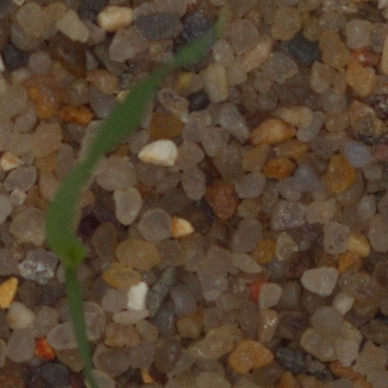

In [19]:
img = PIL.Image.open(f'{PATH}/train/{classes[0]}/{files[1]}'); img

In [20]:
img.size

(388, 388)

## Data pre-processing

In [21]:
from os import listdir
from os.path import join
train_path = f'{PATH}/train'

In [22]:
dirs = [d for d in listdir(train_path) if os.path.isdir(join(train_path,d))]
print(dirs)

['Cleavers', 'Sugar beet', 'Scentless Mayweed', 'Loose Silky-bent', 'Maize', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Fat Hen', 'Charlock', 'Common wheat', 'Black-grass', 'Common Chickweed']


In [23]:
train_dict = {d: listdir(join(train_path,d)) for d in dirs}

In [24]:
train_dict.keys()

dict_keys(['Cleavers', 'Sugar beet', 'Scentless Mayweed', 'Loose Silky-bent', 'Maize', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Fat Hen', 'Charlock', 'Common wheat', 'Black-grass', 'Common Chickweed'])

In [25]:
sum(len(v) for v in train_dict.values())

4750

In [26]:
with open(f'{PATH}/train.csv', 'w') as csv:
    csv.write('img,label\n')
    for d in dirs:
        for f in train_dict[d]: csv.write(f'{f},{d.replace(" ", "_")}\n')

In [27]:
!head {PATH}/train.csv

img,label
0bec204c7.png,Cleavers
d8597aa6a.png,Cleavers
7e8212b65.png,Cleavers
58b68b1ea.png,Cleavers
ef4a36963.png,Cleavers
3a4e50c40.png,Cleavers
0bdee2052.png,Cleavers
6cd9902c0.png,Cleavers
c5f57467a.png,Cleavers


In [28]:
!wc -l {PATH}/train.csv

4751 data/plant-seedlings-classification/train.csv


In [29]:
img_path = f'{PATH}/images'
os.makedirs(img_path, exist_ok=True)

In [30]:
!cp {PATH}/train/*/*.png {PATH}/images/

In [31]:
!ls {PATH}/images | wc -l

4750


## Our first model: quick start

In [ ]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [32]:
arch=resnet34
bs=64
sz=224
csv_fname = os.path.join(PATH, "train.csv")
train_labels = list(open(csv_fname))
n = len(list(open(csv_fname)))-1
val_idxs = get_cv_idxs(n)
tfms = tfms_from_model(arch, sz)
data = ImageClassifierData.from_csv(PATH, "images", csv_fname, bs, tfms, val_idxs, test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 13/13 [00:02<00:00,  5.46it/s]


epoch      trn_loss   val_loss   accuracy   
    0      1.577803   0.937827   0.712632  
    1      1.106689   0.728847   0.785263  



[0.7288474508335716, 0.7852631595260219]

 47%|████▋     | 28/60 [00:00<00:00, 36.28it/s, loss=0.886]


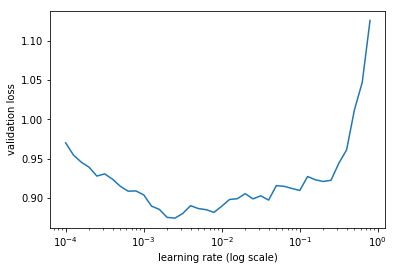

In [33]:
lrf=learn.lr_find()
learn.sched.plot()

In [34]:
learn.fit(0.1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      1.075098   0.729029   0.785263  
    1      1.008579   0.682681   0.806316  
    2      0.876104   0.624643   0.809474  
    3      0.754943   0.482783   0.834737  



[0.4827832806110382, 0.8347368409759119]

### Data augmentation

In [35]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [36]:
def get_augs():
    data = ImageClassifierData.from_csv(PATH, "images", csv_fname, bs, tfms, val_idxs)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [37]:
ims = np.stack([get_augs() for i in range(6)])

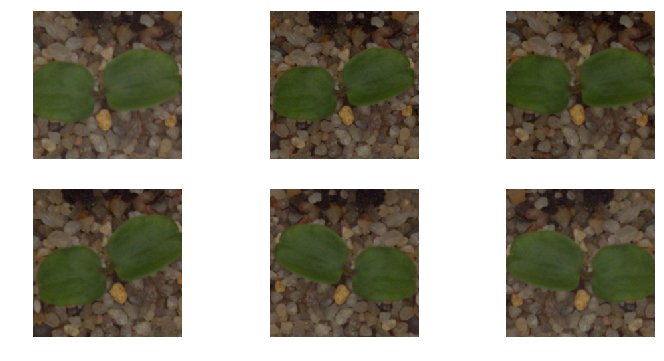

In [38]:
plots(ims, rows=2)

In [39]:
data = ImageClassifierData.from_csv(PATH, 'images', csv_fname, bs, tfms, val_idxs, test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [40]:
learn.fit(0.1, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      1.551622   0.719222   0.764211  
    1      1.319298   0.653978   0.776842  
    2      0.987825   0.529412   0.810526  
    3      0.885812   0.599252   0.798947  
    4      0.771897   0.50594    0.832632  
    5      0.689824   0.435775   0.850526  
    6      0.599243   0.432505   0.852632  
    7      0.655028   0.523069   0.814737  
    8      0.658882   0.520423   0.813684  
    9      0.621197   0.415368   0.862105  
    10     0.57538    0.418109   0.849474  
    11     0.532795   0.388086   0.853684  
    12     0.460011   0.37852    0.863158  
    13     0.446085   0.375332   0.863158  
    14     0.425219   0.37345    0.861053  



[0.37344966982540334, 0.8610526304495962]

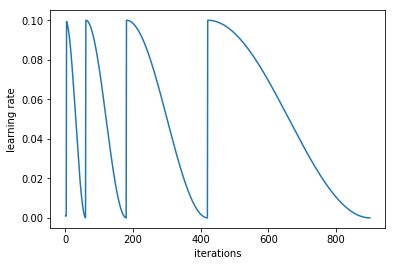

In [41]:
learn.sched.plot_lr()

In [42]:
learn.save('224_plants_lastlayer')

In [43]:
learn.load('224_plants_lastlayer')

### Fine-tuning and differential learning rate annealing

In [44]:
learn.unfreeze()

In [45]:
lr=np.array([0.1/9,0.1/3,0.1])

In [46]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.934542   0.422909   0.847368  
    1      0.586804   0.299206   0.888421  
    2      0.373485   0.184964   0.928421  
    3      0.362769   0.343937   0.871579  
    4      0.285257   0.202737   0.929474  
    5      0.208372   0.138948   0.953684  
    6      0.149252   0.120572   0.961053  



[0.12057220710735572, 0.9610526322063647]

In [47]:
learn.save('224_plants_all')

In [48]:
learn.load('224_plants_all')

In [49]:
(learn.data.test_dl == None)

False

In [50]:
log_preds,y = learn.TTA(is_test=True)

In [51]:
log_preds.shape

(5, 794, 12)

In [52]:
probs = np.exp(log_preds)

In [53]:
probs.shape

(5, 794, 12)

In [54]:
type(probs)

numpy.ndarray

In [55]:
ps = np.exp(probs)

In [56]:
len(np.argmax(ps[0], axis=1))

794

In [57]:
df = pd.DataFrame(np.argmax(ps[0], axis=1))

In [58]:
df.insert(0, 'file', [f[5:] for f in data.test_ds.fnames])

In [59]:
df.columns = ['file', 'species']

In [60]:
class_dict = {i: d for i,d in enumerate(data.classes)}

In [61]:
class_dict

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common_Chickweed',
 4: 'Common_wheat',
 5: 'Fat_Hen',
 6: 'Loose_Silky-bent',
 7: 'Maize',
 8: 'Scentless_Mayweed',
 9: 'Shepherds_Purse',
 10: 'Small-flowered_Cranesbill',
 11: 'Sugar_beet'}

In [62]:
df.head()

,file,species
0,79e5ea8fa.png,4
1,3a909ead8.png,10
2,599691cd9.png,10
3,5ca2687a4.png,7
4,3dd52bd2a.png,10


In [63]:
df["species"] = df["species"].map(class_dict.get)

In [64]:
df.head()

,file,species
0,79e5ea8fa.png,Common_wheat
1,3a909ead8.png,Small-flowered_Cranesbill
2,599691cd9.png,Small-flowered_Cranesbill
3,5ca2687a4.png,Maize
4,3dd52bd2a.png,Small-flowered_Cranesbill


In [65]:
df["species"] = df["species"].map(lambda s: s.replace("_", " "))

In [66]:
df.head()

,file,species
0,79e5ea8fa.png,Common wheat
1,3a909ead8.png,Small-flowered Cranesbill
2,599691cd9.png,Small-flowered Cranesbill
3,5ca2687a4.png,Maize
4,3dd52bd2a.png,Small-flowered Cranesbill


In [67]:
SUBM = f'{PATH}/subm'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}/subm2.gz', compression='gzip', index=False)

In [68]:
FileLink(f'{SUBM}/subm2.gz')

/notebooks/courses/dl1/data/plant-seedlings-classification/subm/subm2.gz

## Review: easy steps to train a world-class image classifier

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

## Analyzing results: loss and accuracy

When we run `learn.fit` we print 3 performance values (see above.) Here 0.03 is the value of the **loss** in the training set, 0.0226 is the value of the loss in the validation set and 0.9927 is the validation accuracy. What is the loss? What is accuracy? Why not to just show accuracy?

**Accuracy** is the ratio of correct prediction to the total number of predictions.

In machine learning the **loss** function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by:
`-(y * log(p) + (1-y) * log (1-p))`
where `y` is the true label of `x` and `p` is the probability predicted by our model that the label is 1.

In [38]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [39]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

Note that in our toy example above our accuracy is 100% and our loss is 0.16. Compare that to a loss of 0.03 that we are getting while predicting cats and dogs. Exercise: play with `preds` to get a lower loss for this example. 

**Example:** Here is an example on how to compute the loss for one example of binary classification problem. Suppose for an image x with label 1 and your model gives it a prediction of 0.9. For this case the loss should be small because our model is predicting a label $1$ with high probability.

`loss = -log(0.9) = 0.10`

Now suppose x has label 0 but our model is predicting 0.9. In this case our loss should be much larger.

loss = -log(1-0.9) = 2.30

- Exercise: look at the other cases and convince yourself that this make sense.
- Exercise: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximize accuracy? The binary classification loss is an easier function to optimize.

## Single prediction

In [73]:
trn_tfms,val_tfms = tfms_from_model(arch, sz)
img = val_tfms(Image.open(PATH+img_path))
learn.predict_array(img[None])
np.argmax(preds)

FileNotFoundError: [Errno 2] No such file or directory: 'data/plant-seedlings-classificationdata/plant-seedlings-classification/images'

## Convert Pytorch to ONNX Model

In [85]:
!mkdir -p models/plant-seedlings-classification

In [86]:
MODEL_PATH = "models/plant-seedlings-classification"

In [84]:
!touch {MODEL_PATH}/pth

touch: cannot touch 'models/plant-seedlings-classification/pth': No such file or directory


In [88]:
learn.save('224_plants_all')

In [89]:
torch.save(learn.model.state_dict(), f'{MODEL_PATH}/pth')

In [90]:
!ls {MODEL_PATH}

pth


In [92]:
!ls ../../storage

lost+found


In [93]:
!cp {MODEL_PATH}/pth ../../storage

In [16]:
pthmodel = torch.load(f'{MODEL_PATH}/pth')